In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,BatchNormalization
from keras.regularizers import l2



In [2]:
def build_and_train_model(xs_train, ys_train, model_config, num_target_features,path_to_save_model):
    """
    Build, train, and evaluate an LSTM model.

    Parameters:
    - xs_train, ys_train: Training data.
    - xs_test, ys_test: Test data.
    - model_config: Dictionary containing LSTM layers configuration and other model parameters.
    - scaler: Scaler used to scale data.
    - num_target_features: Number of output features for the model.

    Returns:
    - model: Trained LSTM model.
    - history: Training history of the model.
    - predictions_rescaled: Rescaled predictions.
    - ys_test_rescaled: Rescaled actual values.
    """
    # # Build the LSTM model
    # # Determine the split index
    # split_index = int(len(xs_train) * 0.8)  # 80% for training, 20% for validation

    # # Split the data sequentially
    # xs_train_split = xs_train[:split_index]
    # ys_train_split = ys_train[:split_index]
    # xs_val_split = xs_train[split_index:]
    # ys_val_split = ys_train[split_index:]
    # num_samples =  xs_train.shape[0]
    # num_time_steps = xs_train.shape[1]
    # num_features = xs_train.shape[2]
    # input_shape = (num_time_steps, num_features)


    # model = Sequential()

    # for layer_config in model_config['cnn_layers']:
    #     model.add(Conv1D(filters=layer_config.get('filters', 32), kernel_size=layer_config.get('kernel_size', 5), activation='relu', input_shape=input_shape))
    #     model.add(MaxPooling1D(pool_size=layer_config.get('pool_size', 2)))
    #      # Reset input_shape after first layer
    #     input_shape = None
        
    #     if 'dropout' in layer_config:
    #         model.add(Dropout(layer_config['dropout']))
            
    # model.add(Flatten())
    # model.add(Dense(num_target_features))
        
    # model.compile(optimizer='adam', loss='mse')

    # Train the model
    # Define the early stopping and model checkpoint callbacks
    # early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)
    # checkpoint = ModelCheckpoint(path_to_save_model, monitor='loss', verbose=1, save_best_only=True, mode='min')

    # history = model.fit(xs_train_split, ys_train_split, epochs=model_config.get('epochs', 50), batch_size=model_config.get('batch_size', 32), validation_data=(xs_val_split, ys_val_split), callbacks=[early_stopping, checkpoint])

    # return model, history
    split_index = int(len(xs_train) * 0.8)  # 80% for training, 20% for validation

    # Split the data sequentially
    xs_train_split = xs_train[:split_index]
    ys_train_split = ys_train[:split_index]
    xs_val_split = xs_train[split_index:]
    ys_val_split = ys_train[split_index:]
    model = Sequential()
    input_shape = (xs_train.shape[1], xs_train.shape[2])

    for layer_config in model_config['lstm_layers']:
        model.add(LSTM(layer_config['units'], activation='tanh', return_sequences=layer_config['return_sequences'],  kernel_regularizer=l2(0.001), input_shape=input_shape if 'input_shape' not in layer_config else None))

        # Reset input_shape after first layer
        input_shape = None

        # Add Dropout layer if specified
        if 'dropout' in layer_config:
            model.add(Dropout(layer_config['dropout']))
        # Optional: Add Batch Normalization
        model.add(BatchNormalization())


    model.add(Dense(num_target_features))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    # Define the early stopping and model checkpoint callbacks
    early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint(path_to_save_model, monitor='loss', verbose=1, save_best_only=True, mode='min')

    history = model.fit(xs_train_split, ys_train_split, epochs=model_config.get('epochs', 50), batch_size=model_config.get('batch_size', 32), validation_data=(xs_val_split, ys_val_split), callbacks=[early_stopping, checkpoint])

    return model, history


In [3]:
def create_sequences(data, seq_length, forecast_horizon, target_columns_idxs):
    xs, ys = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        x = data.iloc[i:(i + seq_length)].values
      #  x = data.iloc[i:(i + seq_length)].drop(columns=[target_col_name]).values 
        y = data.iloc[(i + seq_length):(i + seq_length + forecast_horizon), target_columns_idxs].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Now we need to follow a bit different logic. We need to load our train and our test data from different files

In [4]:
train_data = pd.read_csv('../data/processed/covid-data/train/covid_dataset_train.csv', parse_dates=['Time'], index_col='Time')
test_data = pd.read_csv('../data/processed/covid-data/test/covid_dataset_test.csv', parse_dates=['Time'], index_col='Time')

In [5]:
train_data

,Temperature (C),Wind Direction (deg),Wind Speed (kmh),Forecast_Temperature (C),Forecast_Wind Direction (deg),Forecast_Wind Speed (kmh),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,,,,,,
2017-03-18 00:00:00,16.764386,285.250,6.25375,14.0,307,2.0,0.000000e+00,1.000000,1.031472e+06
2017-03-18 01:00:00,15.729386,285.000,9.20500,14.0,215,2.0,2.588190e-01,0.965926,1.007206e+06
2017-03-18 02:00:00,15.816886,316.000,11.28375,14.0,123,1.0,5.000000e-01,0.866025,9.861084e+05
2017-03-18 03:00:00,15.919386,327.000,7.16875,14.0,31,1.0,7.071068e-01,0.707107,9.707610e+05
2017-03-18 04:00:00,15.769386,282.250,0.78000,14.0,138,1.0,8.660254e-01,0.500000,9.622584e+05
...,...,...,...,...,...,...,...,...,...
2020-06-26 11:00:00,21.531886,224.125,19.25000,18.0,213,22.0,2.588190e-01,-0.965926,1.197810e+06
2020-06-26 12:00:00,22.391886,215.875,19.48625,20.0,209,22.0,1.224647e-16,-1.000000,1.191897e+06
2020-06-26 13:00:00,22.316886,221.125,20.06875,20.0,211,23.0,-2.588190e-01,-0.965926,1.189634e+06


In [6]:
test_data

,Temperature (C),Wind Direction (deg),Wind Speed (kmh),Forecast_Temperature (C),Forecast_Wind Direction (deg),Forecast_Wind Speed (kmh),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,,,,,,
2020-06-26 16:00:00,20.161886,215.375000,17.596250,20.0,213,24.0,-8.660254e-01,-5.000000e-01,1.156928e+06
2020-06-26 17:00:00,19.799386,208.250000,16.848750,18.0,212,24.0,-9.659258e-01,-2.588190e-01,1.124039e+06
2020-06-26 18:00:00,19.871886,204.875000,17.692500,18.0,212,23.0,-1.000000e+00,-1.836970e-16,1.073085e+06
2020-06-26 19:00:00,18.571886,207.000000,16.220000,18.0,210,23.0,-9.659258e-01,2.588190e-01,1.056702e+06
2020-06-26 20:00:00,17.746886,204.500000,23.016250,18.0,208,22.0,-8.660254e-01,5.000000e-01,1.048415e+06
...,...,...,...,...,...,...,...,...,...
2020-11-06 11:00:00,21.299386,335.250000,8.280000,18.0,264,11.0,2.588190e-01,-9.659258e-01,1.242830e+06
2020-11-06 12:00:00,22.419386,261.250000,11.466250,20.0,332,12.0,1.224647e-16,-1.000000e+00,1.239480e+06
2020-11-06 13:00:00,22.971886,296.250000,14.507500,20.0,328,14.0,-2.588190e-01,-9.659258e-01,1.234773e+06


In [7]:
train_data.columns

Index(['Temperature (C)', 'Wind Direction (deg)', 'Wind Speed (kmh)',
       'Forecast_Temperature (C)', 'Forecast_Wind Direction (deg)',
       'Forecast_Wind Speed (kmh)', 'hour_of_day_sin', 'hour_of_day_cos',
       'Load (kW)'],
      dtype='object')

In [8]:
#columns_to_correct=['Temperature (C)', 'Forecast_Temperature (C)']
columns_to_correct= ['Temperature (C)','Forecast_Temperature (C)']
original_columns = train_data.columns
print('Original columns:', original_columns)
original_test_data =  test_data
origial_train_data = train_data

train_data = train_data.loc[:,columns_to_correct]
test_data = test_data.loc[:,columns_to_correct]
test_data

Original columns: Index(['Temperature (C)', 'Wind Direction (deg)', 'Wind Speed (kmh)',
       'Forecast_Temperature (C)', 'Forecast_Wind Direction (deg)',
       'Forecast_Wind Speed (kmh)', 'hour_of_day_sin', 'hour_of_day_cos',
       'Load (kW)'],
      dtype='object')


,Temperature (C),Forecast_Temperature (C)
Time,,
2020-06-26 16:00:00,20.161886,20.0
2020-06-26 17:00:00,19.799386,18.0
2020-06-26 18:00:00,19.871886,18.0
2020-06-26 19:00:00,18.571886,18.0
2020-06-26 20:00:00,17.746886,18.0
...,...,...
2020-11-06 11:00:00,21.299386,18.0
2020-11-06 12:00:00,22.419386,20.0
2020-11-06 13:00:00,22.971886,20.0


# Our goal is to model residuals in order to create the initial forecasts 

In [9]:
actual_columns = [col for col in train_data.columns if 'Forecast_' not in col]
forecast_columns = [col for col in train_data.columns if 'Forecast_' in col]

# Our goal is to predict the next hour of data
forecast_horizon = 1

# We will use the last 24 hours of data to make the prediction
lookback = 12

print('Actual columns:', actual_columns)
print('Forecast columns:', forecast_columns)

Actual columns: ['Temperature (C)']
Forecast columns: ['Forecast_Temperature (C)']


Now because we keep out files seperately we need to do the same process twice both for train and test data

In [10]:
# First we need to bring our data into a format
# inputs - tartet
# Forecast columns - Residual columns(target)
# Creating an empty DataFrame to store residuals
residuals_df_train = pd.DataFrame(index=train_data.index)
residuals_df_test = pd.DataFrame(index=test_data.index)

actuals_df_train = train_data[actual_columns]
actuals_df_test = train_data[actual_columns]

# Loop over actual columns to calculate residuals
for actual_col in actual_columns:
    forecast_col = f"Forecast_{actual_col}"
    if forecast_col in forecast_columns:
        residuals_df_train[f"Residual_{actual_col}"] = train_data[actual_col] - train_data[forecast_col]
        residuals_df_test[f"Residual_{actual_col}"] = test_data[actual_col] - test_data[forecast_col]


In [11]:
residuals_cols = [col for col in residuals_df_train.columns if 'Residual_' in col]
residuals_cols

['Residual_Temperature (C)']

In [12]:
num_target_features = len(residuals_cols) 
num_target_features

1

In [13]:
# reordering the columns of the two datasets to be similar
#Otherwise, we will end up correcting the wrong forecast with the wrong residual
# Extract base names for ordering
base_names = [col.replace('Forecast_', '') for col in forecast_columns]

# Create the ordered list of forecast and residual columns
ordered_forecast_columns = forecast_columns
ordered_residual_columns = [col for base in base_names for col in residuals_cols if col.replace('Residual_', '') == base]
ordered_actual_columns = base_names
# Reorder DataFrames for train
train_df_forecast = train_data[ordered_forecast_columns]
train_df_residuals = residuals_df_train[ordered_residual_columns]
train_df_actuals = actuals_df_train[ordered_actual_columns]

# Reorder DataFrames for test
test_df_forecast = test_data[ordered_forecast_columns]
test_df_residuals = residuals_df_test[ordered_residual_columns]
train_df_actuals = actuals_df_test[ordered_actual_columns]


forecast_columns = ordered_forecast_columns
actual_columns = ordered_actual_columns
residuals_cols = train_df_residuals.columns
print('Reordered Residual columns:', residuals_cols)
print('Reordered Forecasts columns:', forecast_columns)
print('Reordered Actual columns:', actual_columns)

Reordered Residual columns: Index(['Residual_Temperature (C)'], dtype='object')
Reordered Forecasts columns: ['Forecast_Temperature (C)']
Reordered Actual columns: ['Temperature (C)']


In [14]:
train_df_residuals

,Residual_Temperature (C)
Time,
2017-03-18 00:00:00,2.764386
2017-03-18 01:00:00,1.729386
2017-03-18 02:00:00,1.816886
2017-03-18 03:00:00,1.919386
2017-03-18 04:00:00,1.769386
...,...
2020-06-26 11:00:00,3.531886
2020-06-26 12:00:00,2.391886
2020-06-26 13:00:00,2.316886


In [15]:
train_df_forecast

,Forecast_Temperature (C)
Time,
2017-03-18 00:00:00,14.0
2017-03-18 01:00:00,14.0
2017-03-18 02:00:00,14.0
2017-03-18 03:00:00,14.0
2017-03-18 04:00:00,14.0
...,...
2020-06-26 11:00:00,18.0
2020-06-26 12:00:00,20.0
2020-06-26 13:00:00,20.0


In [16]:
train_data.loc[:,actual_columns]

,Temperature (C)
Time,
2017-03-18 00:00:00,16.764386
2017-03-18 01:00:00,15.729386
2017-03-18 02:00:00,15.816886
2017-03-18 03:00:00,15.919386
2017-03-18 04:00:00,15.769386
...,...
2020-06-26 11:00:00,21.531886
2020-06-26 12:00:00,22.391886
2020-06-26 13:00:00,22.316886


In [17]:
weather_df_train = pd.concat([train_df_forecast, train_df_residuals], axis=1)
weather_df_test = pd.concat([test_df_forecast, test_df_residuals], axis=1)

In [18]:
weather_df_train

,Forecast_Temperature (C),Residual_Temperature (C)
Time,,
2017-03-18 00:00:00,14.0,2.764386
2017-03-18 01:00:00,14.0,1.729386
2017-03-18 02:00:00,14.0,1.816886
2017-03-18 03:00:00,14.0,1.919386
2017-03-18 04:00:00,14.0,1.769386
...,...,...
2020-06-26 11:00:00,18.0,3.531886
2020-06-26 12:00:00,20.0,2.391886
2020-06-26 13:00:00,20.0,2.316886


In [19]:
weather_df_test

,Forecast_Temperature (C),Residual_Temperature (C)
Time,,
2020-06-26 16:00:00,20.0,0.161886
2020-06-26 17:00:00,18.0,1.799386
2020-06-26 18:00:00,18.0,1.871886
2020-06-26 19:00:00,18.0,0.571886
2020-06-26 20:00:00,18.0,-0.253114
...,...,...
2020-11-06 11:00:00,18.0,3.299386
2020-11-06 12:00:00,20.0,2.419386
2020-11-06 13:00:00,20.0,2.971886


In [20]:
#1. Scale data
scaler = MinMaxScaler()
weather_df_train_scaled = pd.DataFrame(scaler.fit_transform(weather_df_train), columns=weather_df_train.columns, index=weather_df_train.index)
weather_df_test_scaled = pd.DataFrame(scaler.fit_transform(weather_df_test), columns=weather_df_test.columns, index=weather_df_test.index)

In [21]:
weather_df_train_scaled

,Forecast_Temperature (C),Residual_Temperature (C)
Time,,
2017-03-18 00:00:00,0.384615,0.588676
2017-03-18 01:00:00,0.384615,0.556965
2017-03-18 02:00:00,0.384615,0.559646
2017-03-18 03:00:00,0.384615,0.562787
2017-03-18 04:00:00,0.384615,0.558191
...,...,...
2020-06-26 11:00:00,0.538462,0.612192
2020-06-26 12:00:00,0.615385,0.577264
2020-06-26 13:00:00,0.615385,0.574966


In [22]:
weather_df_test_scaled

,Forecast_Temperature (C),Residual_Temperature (C)
Time,,
2020-06-26 16:00:00,0.666667,0.538644
2020-06-26 17:00:00,0.583333,0.612547
2020-06-26 18:00:00,0.583333,0.615819
2020-06-26 19:00:00,0.583333,0.557148
2020-06-26 20:00:00,0.583333,0.519914
...,...,...
2020-11-06 11:00:00,0.583333,0.680244
2020-11-06 12:00:00,0.666667,0.640528
2020-11-06 13:00:00,0.666667,0.665463


In [23]:
#2. Create sequences
target_columns_idxs = [weather_df_train.columns.get_loc(col) for col in residuals_cols]
print("Target columns indexes:",target_columns_idxs)
xs_train_scaled, ys_train_scaled = create_sequences(weather_df_train_scaled, lookback, forecast_horizon,target_columns_idxs)
xs_test_scaled, ys_test_scaled = create_sequences(weather_df_test_scaled, lookback, forecast_horizon,target_columns_idxs)


Target columns indexes: [1]


In [24]:
xs_test_scaled

array([[[0.66666667, 0.5386438 ],
        [0.58333333, 0.61254654],
        [0.58333333, 0.61581857],
        ...,
        [0.5       , 0.50874422],
        [0.5       , 0.45571477],
        [0.5       , 0.51607808]],

       [[0.58333333, 0.61254654],
        [0.58333333, 0.61581857],
        [0.58333333, 0.55714769],
        ...,
        [0.5       , 0.45571477],
        [0.5       , 0.51607808],
        [0.5       , 0.48843507]],

       [[0.58333333, 0.61581857],
        [0.58333333, 0.55714769],
        [0.58333333, 0.51991425],
        ...,
        [0.5       , 0.51607808],
        [0.5       , 0.48843507],
        [0.5       , 0.49306104]],

       ...,

       [[0.5       , 0.41464515],
        [0.5       , 0.39286923],
        [0.5       , 0.38136071],
        ...,
        [0.58333333, 0.59415548],
        [0.58333333, 0.68024371],
        [0.66666667, 0.64052804]],

       [[0.5       , 0.39286923],
        [0.5       , 0.38136071],
        [0.5       , 0.36522622],
        .

In [25]:
ys_test_scaled

array([[[0.48843507]],

       [[0.49306104]],

       [[0.54721877]],

       ...,

       [[0.66546316]],

       [[0.81631502]],

       [[0.80807853]]])

In [26]:
#4. Define the model configuration
# model_config = {
#     'lstm_layers': [
#       {'units': 128, 'return_sequences': True, 'dropout': 0.2},
#       {'units': 64, 'return_sequences': True, 'dropout': 0.2},
#       {'units': 64, 'return_sequences': False},

#       #{'units': 32, 'return_sequences': True, 'dropout': 0.2},

#       #{'units': 32, 'return_sequences': True, 'dropout': 0.2},
#    #   {'units': 16, 'return_sequences':False},
#      # {'units': 32, 'return_sequences': True, 'dropout': 0.2},
#      # {'units': 16, 'return_sequences': True, 'dropout': 0.2},
#       #{'units': 16, 'return_sequences': True, 'dropout': 0.2},
#      #  {'units': 8, 'return_sequences': False}
#     ],
#     'epochs': 20,
#     'batch_size': 64
# }

# lookback = 12
# model_config = {
#     'lstm_layers': [
#       {'units': 128, 'return_sequences': True, 'dropout': 0.2},
#       #{'units': 16, 'return_sequences': True, 'dropout': 0.2},
#       # {'units':8, 'return_sequences': False}
#     ],
#     'epochs': 10,
#     'batch_size': 32
# }

#lookback = 16
# model_config = {
#    'cnn_layers': [
#     {'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'pool_size': 2, 'dropout': 0.2},
#     {'filters': 64, 'kernel_size':2, 'activation': 'relu', 'pool_size': 2, 'dropout': 0.2},
#      {'filters': 32, 'kernel_size':2, 'activation': 'relu', 'pool_size': 2, 'dropout': 0.2}
#     ],
#     'epochs': 300,
#     'batch_size': 64
# }

# lookback = 8
# model_config = {
#     'lstm_layers': [
#               {'units': 128, 'return_sequences': True, 'dropout': 0.8},
#              {'units': 16, 'return_sequences': True, 'dropout': 0.3},

#               {'units': 8, 'return_sequences': True, 'dropout': 0.3},

#      {'units': 4, 'return_sequences':False},
#      #     {'units': 8, 'return_sequences': True, 'dropout': 0.2},

#      # {'units': 4, 'return_sequences':False},
#      #  {'units': 4, 'return_sequences': False}
#     ],
#     # 'cnn_layers': [
#     #     {'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 2, 'dropout': 0.2}, #Οutput shape: (None, 3, 64)
#     # ],
#     'epochs': 20,
#     'batch_size': 128
# }

# model_config = {
#     'lstm_layers': [
#               {'units': 64, 'return_sequences': True, 'dropout': 0.2},

#      {'units': 16, 'return_sequences':False},
#      #     {'units': 8, 'return_sequences': True, 'dropout': 0.2},

#      # {'units': 4, 'return_sequences':False},
#      #  {'units': 4, 'return_sequences': False}
#     ],
#     # 'cnn_layers': [
#     #     {'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 2, 'dropout': 0.2}, #Οutput shape: (None, 3, 64)
#     # ],
#     'epochs': 10,
#     'batch_size': 128
# }
# no overfitting
#lookback = 8

model_config = {
    'lstm_layers': [
     {'units': 32, 'return_sequences': True, 'dropout': 0.2},
     {'units': 16, 'return_sequences': True, 'dropout': 0.2},
     {'units': 4, 'return_sequences':False},
    ],
    'epochs': 10,
    'batch_size': 64
}




In [27]:
#5. Build, train, and evaluate the model
multivariate_weather_residuals_foreacasting_modelpath = '../models/multivariate_weather_residuals_foreacasting_modelpath.keras'
model, history = build_and_train_model(
    xs_train_scaled, ys_train_scaled, model_config, num_target_features, path_to_save_model = multivariate_weather_residuals_foreacasting_modelpath
)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


354/359 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0724
Epoch 1: loss improved from inf to 0.04423, saving model to ../models/multivariate_weather_residuals_foreacasting_modelpath.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0720 - val_loss: 0.0279
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210
Epoch 2: loss improved from 0.04423 to 0.01899, saving model to ../models/multivariate_weather_residuals_foreacasting_modelpath.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0210 - val_loss: 0.0196
Epoch 3/10
351/359 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145
Epoch 3: loss improved from 0.01899 to 0.01396, saving model to ../models/multivariate_weather_residuals_foreacasting_modelpath.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0145 - val_loss: 0.0170
Epoch 4/10
349/359 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123
Epoch 4: loss improved from 0.01396 to 0.01164, saving model to ../models/multivariate_weather_residuals_foreacasting_mo

In [28]:
#7. Evaluate the model
loss = model.evaluate(xs_test_scaled, ys_test_scaled)
print(f'Test Loss: {loss}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 0.0079
Test Loss: 0.009202644228935242


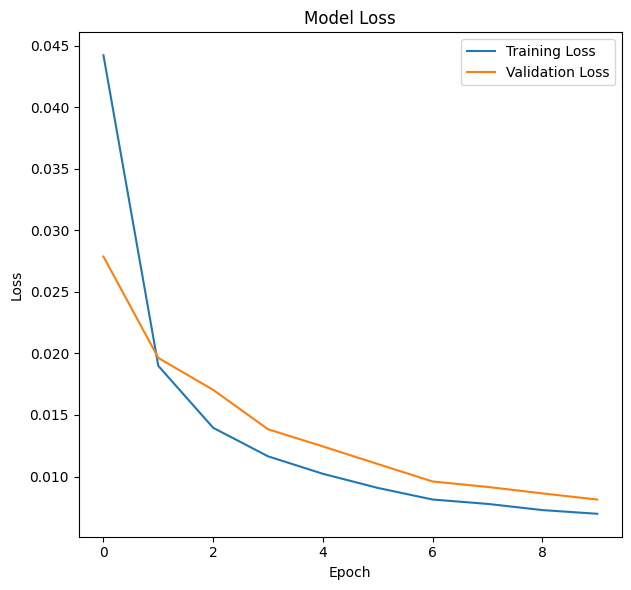

In [29]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [30]:
#8. Make predictions
# Make predictions on the test set
predictions_scaled = model.predict(xs_test_scaled) # contains only load
predictions_scaled

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0.4950641 ],
       [0.49557993],
       [0.4983436 ],
       ...,
       [0.6362015 ],
       [0.6461297 ],
       [0.67556167]], dtype=float32)

In [31]:
predictions_scaled.shape[0]

3180

## Goal is to correct our test initial values and store them in a new dataset

In [32]:
# Padding with zeros to match the shape of the scaler
# Rescale the forecasts and residuals columns
# but our scaler was trained on all columns so we have to inverse transform all columns
# so we need to padd with zeros the other columns
num_of_missing_features = weather_df_test.shape[1] - num_target_features 

padding_for_missing_features = np.zeros((num_of_missing_features,predictions_scaled.shape[0]))
padding_for_missing_features = padding_for_missing_features.astype(np.float32)
print(predictions_scaled.shape)
padding_for_missing_features

(3180, 1)


array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
data_to_be_invert_from_scaling = np.hstack([padding_for_missing_features.T, predictions_scaled])
data_to_be_invert_from_scaling

array([[0.        , 0.4950641 ],
       [0.        , 0.49557993],
       [0.        , 0.4983436 ],
       ...,
       [0.        , 0.6362015 ],
       [0.        , 0.6461297 ],
       [0.        , 0.67556167]], dtype=float32)

# Invert the scaling be careful here to choose the right column index

In [34]:
#Invert the scaling and take the actual residuals predictictions
residuals_predictions= scaler.inverse_transform(data_to_be_invert_from_scaling)[:, target_columns_idxs]
residuals_predictions

array([[-0.8037308 ],
       [-0.79230154],
       [-0.73106575],
       ...,
       [ 2.323521  ],
       [ 2.5435057 ],
       [ 3.195644  ]], dtype=float32)

In [35]:
residuals_predictions_df = pd.DataFrame(residuals_predictions, columns= residuals_cols, index=test_data[lookback:].index)
residuals_predictions_df

,Residual_Temperature (C)
Time,
2020-06-27 04:00:00,-0.803731
2020-06-27 05:00:00,-0.792302
2020-06-27 06:00:00,-0.731066
2020-06-27 07:00:00,-0.397621
2020-06-27 08:00:00,0.108814
...,...
2020-11-06 11:00:00,-0.768709
2020-11-06 12:00:00,1.212525
2020-11-06 13:00:00,2.323521


In [36]:
test_data[lookback:]

,Temperature (C),Forecast_Temperature (C)
Time,,
2020-06-27 04:00:00,15.049386,16.0
2020-06-27 05:00:00,15.151886,16.0
2020-06-27 06:00:00,16.351886,16.0
2020-06-27 07:00:00,16.761886,16.0
2020-06-27 08:00:00,17.396886,18.0
...,...,...
2020-11-06 11:00:00,21.299386,18.0
2020-11-06 12:00:00,22.419386,20.0
2020-11-06 13:00:00,22.971886,20.0


In [37]:
# Correct forecasts
corrected_forecasts = test_data[lookback:][forecast_columns] + residuals_predictions
corrected_forecasts

,Forecast_Temperature (C)
Time,
2020-06-27 04:00:00,15.196269
2020-06-27 05:00:00,15.207698
2020-06-27 06:00:00,15.268934
2020-06-27 07:00:00,15.602379
2020-06-27 08:00:00,18.108814
...,...
2020-11-06 11:00:00,17.231291
2020-11-06 12:00:00,21.212525
2020-11-06 13:00:00,22.323521


In [38]:
test_indices = test_data.index[lookback:]
test_indices

DatetimeIndex(['2020-06-27 04:00:00', '2020-06-27 05:00:00',
               '2020-06-27 06:00:00', '2020-06-27 07:00:00',
               '2020-06-27 08:00:00', '2020-06-27 09:00:00',
               '2020-06-27 10:00:00', '2020-06-27 11:00:00',
               '2020-06-27 12:00:00', '2020-06-27 13:00:00',
               ...
               '2020-11-06 06:00:00', '2020-11-06 07:00:00',
               '2020-11-06 08:00:00', '2020-11-06 09:00:00',
               '2020-11-06 10:00:00', '2020-11-06 11:00:00',
               '2020-11-06 12:00:00', '2020-11-06 13:00:00',
               '2020-11-06 14:00:00', '2020-11-06 15:00:00'],
              dtype='datetime64[ns]', name='Time', length=3180, freq=None)

In [39]:
actual_test_data = test_data[lookback:][actual_columns]
forecasts_test_data = test_data[lookback:][forecast_columns]

In [40]:
corrected_forecasts_index = corrected_forecasts.index
corrected_forecasts = np.array(corrected_forecasts)
corrected_forecasts_df = pd.DataFrame(corrected_forecasts, columns=forecast_columns, index=corrected_forecasts_index)
test_indices = test_data.index[lookback:]
feature_names = actual_test_data.columns

In [41]:
corrected_forecasts_df.columns

Index(['Forecast_Temperature (C)'], dtype='object')

In [42]:
actual_test_data.columns

Index(['Temperature (C)'], dtype='object')

In [43]:
forecasts_test_data.columns

Index(['Forecast_Temperature (C)'], dtype='object')

mse_initial 10.134579983145416
mse_adjusted 3.5855181370181834


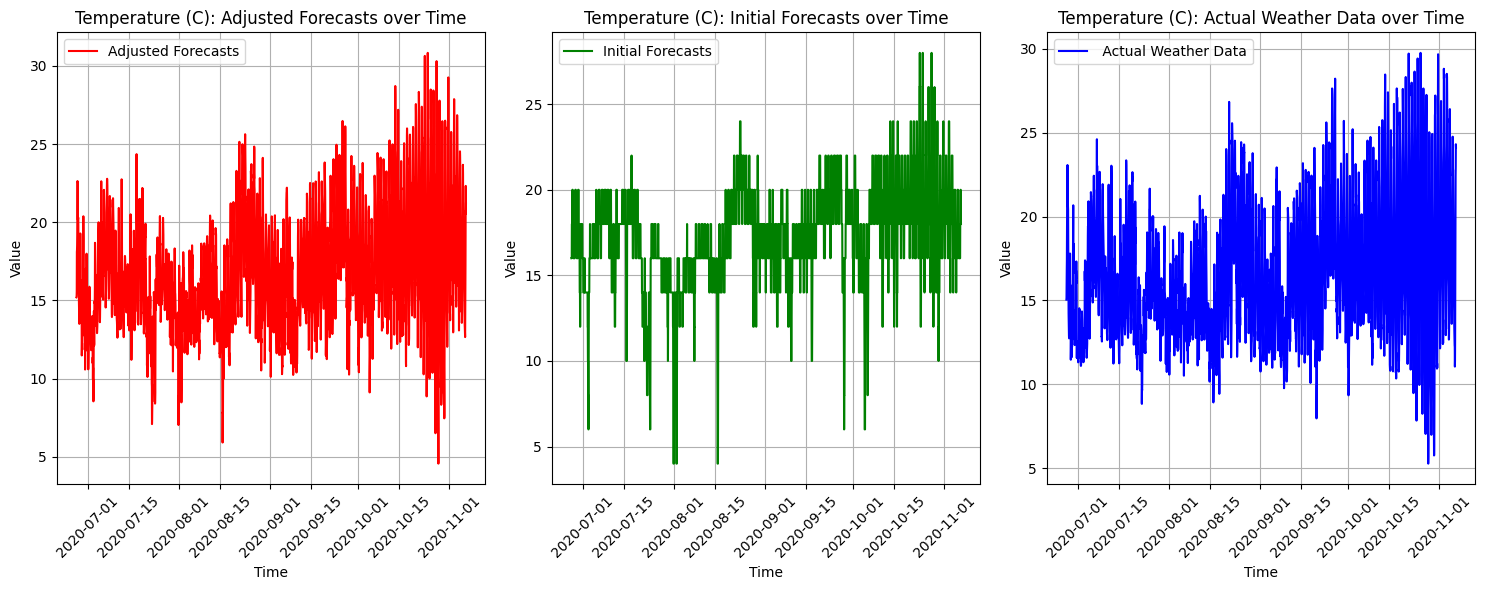

In [44]:
from sklearn.metrics import mean_squared_error

for i in range(num_target_features):
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))  # Create a figure with 2 subplots side by side
    
    # Access DataFrame using .iloc
    #plt.plot(test_indices, xs_test_actuals.iloc[lookback:, i], label="Actual", color='blue')
    axes[0].plot(test_indices,corrected_forecasts_df.iloc[:, i], label="Adjusted Forecasts", color='red')
   # axes[0].plot(test_indices, actual_test_data.iloc[:,i], label=" Actual Weather Data", color='blue', alpha=0.7)
    axes[0].set_title(f"{feature_names[i]}: Adjusted Forecasts over Time")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Value")
    axes[0].legend()
    axes[0].grid(True)
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Plot the initial forecasts in the second subplot
    axes[1].plot(test_indices, forecasts_test_data.iloc[:,i], label="Initial Forecasts", color='green')
    axes[1].set_title(f"{feature_names[i]}: Initial Forecasts over Time")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Value")
    axes[1].legend()
    axes[1].grid(True)
    axes[1].tick_params(axis='x', rotation=45) 


    # Plot the initial forecasts in the second subplot
    axes[2].plot(test_indices, actual_test_data.iloc[:,i], label=" Actual Weather Data", color='blue')
    #axes[2].plot(test_indices,forecasts_test_data.iloc[:, i], label="Initial Forecasts", color='yellow', alpha=0.7)
    #axes[2].plot(test_indices, corrected_forecasts_df.iloc[:, i], label="Adjusted Forecasts", color='red', alpha=0.7)
    axes[2].set_title(f"{feature_names[i]}: Actual Weather Data over Time")
    axes[2].set_xlabel("Time")
    axes[2].set_ylabel("Value")
    axes[2].legend()
    axes[2].grid(True)
    axes[2].tick_params(axis='x', rotation=45) 

    mse_initial = mean_squared_error(actual_test_data.iloc[:, i], forecasts_test_data.iloc[:, i])
    mse_adjusted = mean_squared_error(actual_test_data.iloc[:, i], corrected_forecasts_df.iloc[:, i])
    
    print('mse_initial',mse_initial)
    print('mse_adjusted',mse_adjusted)

    plt.tight_layout()
    plt.show()

In [45]:
corrected_forecasts_df.iloc[:, i]

Time
2020-06-27 04:00:00    15.196269
2020-06-27 05:00:00    15.207698
2020-06-27 06:00:00    15.268934
2020-06-27 07:00:00    15.602379
2020-06-27 08:00:00    18.108814
                         ...    
2020-11-06 11:00:00    17.231291
2020-11-06 12:00:00    21.212525
2020-11-06 13:00:00    22.323521
2020-11-06 14:00:00    20.543506
2020-11-06 15:00:00    21.195644
Name: Forecast_Temperature (C), Length: 3180, dtype: float64

In [46]:
forecasts_test_data.iloc[:, i]

Time
2020-06-27 04:00:00    16.0
2020-06-27 05:00:00    16.0
2020-06-27 06:00:00    16.0
2020-06-27 07:00:00    16.0
2020-06-27 08:00:00    18.0
                       ... 
2020-11-06 11:00:00    18.0
2020-11-06 12:00:00    20.0
2020-11-06 13:00:00    20.0
2020-11-06 14:00:00    18.0
2020-11-06 15:00:00    18.0
Name: Forecast_Temperature (C), Length: 3180, dtype: float64

In [47]:
actual_test_data.iloc[:, i]

Time
2020-06-27 04:00:00    15.049386
2020-06-27 05:00:00    15.151886
2020-06-27 06:00:00    16.351886
2020-06-27 07:00:00    16.761886
2020-06-27 08:00:00    17.396886
                         ...    
2020-11-06 11:00:00    21.299386
2020-11-06 12:00:00    22.419386
2020-11-06 13:00:00    22.971886
2020-11-06 14:00:00    24.314386
2020-11-06 15:00:00    24.131886
Name: Temperature (C), Length: 3180, dtype: float64

# Save the new corrected test weather variables to a new dataset file file

In [48]:
test_data.columns

Index(['Temperature (C)', 'Forecast_Temperature (C)'], dtype='object')

In [49]:
load_column_df = original_test_data.iloc[lookback:, [original_test_data.columns.get_loc('Load (kW)')]]
wind_direction = original_test_data.iloc[lookback:, [original_test_data.columns.get_loc('Wind Direction (deg)')]]
wind_speed = original_test_data.iloc[lookback:, [original_test_data.columns.get_loc('Wind Speed (kmh)')]]

hour_of_day_sin = original_test_data.iloc[lookback:, [original_test_data.columns.get_loc('hour_of_day_sin')]]
hour_of_day_cos = original_test_data.iloc[lookback:, [original_test_data.columns.get_loc('hour_of_day_cos')]]

load_column_df

,Load (kW)
Time,
2020-06-27 04:00:00,9.705132e+05
2020-06-27 05:00:00,9.694804e+05
2020-06-27 06:00:00,9.644836e+05
2020-06-27 07:00:00,9.810288e+05
2020-06-27 08:00:00,1.021520e+06
...,...
2020-11-06 11:00:00,1.242830e+06
2020-11-06 12:00:00,1.239480e+06
2020-11-06 13:00:00,1.234773e+06


In [50]:
corrected_forecasts_df.columns

Index(['Forecast_Temperature (C)'], dtype='object')

In [51]:
corrected_forecasts_df

,Forecast_Temperature (C)
Time,
2020-06-27 04:00:00,15.196269
2020-06-27 05:00:00,15.207698
2020-06-27 06:00:00,15.268934
2020-06-27 07:00:00,15.602379
2020-06-27 08:00:00,18.108814
...,...
2020-11-06 11:00:00,17.231291
2020-11-06 12:00:00,21.212525
2020-11-06 13:00:00,22.323521


In [52]:
corrected_forecasts_df.columns = corrected_forecasts_df.columns.str.replace('Forecast_', '')
corrected_forecasts
final_dataset = pd.concat([corrected_forecasts_df, wind_direction, wind_speed, hour_of_day_sin, hour_of_day_cos, load_column_df], axis=1)
final_dataset

,Temperature (C),Wind Direction (deg),Wind Speed (kmh),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,,,
2020-06-27 04:00:00,15.196269,191.875000,12.735000,8.660254e-01,5.000000e-01,9.705132e+05
2020-06-27 05:00:00,15.207698,198.750000,10.255000,9.659258e-01,2.588190e-01,9.694804e+05
2020-06-27 06:00:00,15.268934,212.750000,14.287500,1.000000e+00,6.123234e-17,9.644836e+05
2020-06-27 07:00:00,15.602379,217.250000,14.232500,9.659258e-01,-2.588190e-01,9.810288e+05
2020-06-27 08:00:00,18.108814,207.250000,15.480000,8.660254e-01,-5.000000e-01,1.021520e+06
...,...,...,...,...,...,...
2020-11-06 11:00:00,17.231291,335.250000,8.280000,2.588190e-01,-9.659258e-01,1.242830e+06
2020-11-06 12:00:00,21.212525,261.250000,11.466250,1.224647e-16,-1.000000e+00,1.239480e+06
2020-11-06 13:00:00,22.323521,296.250000,14.507500,-2.588190e-01,-9.659258e-01,1.234773e+06


In [53]:
final_dataset

,Temperature (C),Wind Direction (deg),Wind Speed (kmh),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,,,
2020-06-27 04:00:00,15.196269,191.875000,12.735000,8.660254e-01,5.000000e-01,9.705132e+05
2020-06-27 05:00:00,15.207698,198.750000,10.255000,9.659258e-01,2.588190e-01,9.694804e+05
2020-06-27 06:00:00,15.268934,212.750000,14.287500,1.000000e+00,6.123234e-17,9.644836e+05
2020-06-27 07:00:00,15.602379,217.250000,14.232500,9.659258e-01,-2.588190e-01,9.810288e+05
2020-06-27 08:00:00,18.108814,207.250000,15.480000,8.660254e-01,-5.000000e-01,1.021520e+06
...,...,...,...,...,...,...
2020-11-06 11:00:00,17.231291,335.250000,8.280000,2.588190e-01,-9.659258e-01,1.242830e+06
2020-11-06 12:00:00,21.212525,261.250000,11.466250,1.224647e-16,-1.000000e+00,1.239480e+06
2020-11-06 13:00:00,22.323521,296.250000,14.507500,-2.588190e-01,-9.659258e-01,1.234773e+06


In [54]:



final_dataset.to_csv('../data/processed/covid-data/test/covid_dataset_corrected_weather_forecasts.csv')
final_dataset

,Temperature (C),Wind Direction (deg),Wind Speed (kmh),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,,,
2020-06-27 04:00:00,15.196269,191.875000,12.735000,8.660254e-01,5.000000e-01,9.705132e+05
2020-06-27 05:00:00,15.207698,198.750000,10.255000,9.659258e-01,2.588190e-01,9.694804e+05
2020-06-27 06:00:00,15.268934,212.750000,14.287500,1.000000e+00,6.123234e-17,9.644836e+05
2020-06-27 07:00:00,15.602379,217.250000,14.232500,9.659258e-01,-2.588190e-01,9.810288e+05
2020-06-27 08:00:00,18.108814,207.250000,15.480000,8.660254e-01,-5.000000e-01,1.021520e+06
...,...,...,...,...,...,...
2020-11-06 11:00:00,17.231291,335.250000,8.280000,2.588190e-01,-9.659258e-01,1.242830e+06
2020-11-06 12:00:00,21.212525,261.250000,11.466250,1.224647e-16,-1.000000e+00,1.239480e+06
2020-11-06 13:00:00,22.323521,296.250000,14.507500,-2.588190e-01,-9.659258e-01,1.234773e+06
